In [1]:
import sys
sys.dont_write_bytecode = True

import torch 
import numpy as np 
import open3d as o3d  # type: ignore
from projections import camera_to_image, world_to_camera, filter_pixel_points
from utils import get_cameras, get_extrinsic_matrix, get_intrinsic_matrix 
from utils import save_ply

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Read the point cloud
gaussian_file = './point_cloud/iteration_30000/point_cloud.ply' 

In [3]:
pcd = o3d.io.read_point_cloud(gaussian_file)

In [4]:
pcd_array = np.asarray(pcd.points)
pcd_array = torch.from_numpy(pcd_array)
print(pcd_array)

tensor([[ -0.1773,   1.4565,  -0.6173],
        [ -0.2395,  -0.2551,   1.3519],
        [ -0.5875,  -0.3807,  -0.1670],
        ...,
        [ 14.6480,  -0.6251, -26.5749],
        [  0.2383,  -8.9183,  24.5446],
        [-34.5657,  -8.3790,   3.8361]], dtype=torch.float64)


In [5]:
# save_ply(pcd_array) 

### Converting World Coordinates to Pixel Coordinates

In [6]:
# Get Cameras 

cameras = get_cameras('cameras.json')  
i = 15
print('Image Name: ', cameras[i]['img_name'])

# WIDTH = cameras[i]['width'] 
# HEIGHT = cameras[i]['height'] 

WIDTH = cameras[i]['width'] 
HEIGHT = cameras[i]['height']

# Get Extrinsic & intrinsic Matrices for first camera 
extrinsic = get_extrinsic_matrix(cameras[i])  
intrinsic = get_intrinsic_matrix(cameras[i]) 

Image Name:  000121


In [7]:
# Convert to Camera Coordinates 
camera_coords = world_to_camera(pcd_array, extrinsic) 
print(camera_coords) 

tensor([[ -5.9571,  -3.8051,  -5.3095,  ..., -30.9991,  20.2418,  -1.5109],
        [  1.1921,  -0.2831,  -0.6213,  ...,  -1.8150,  -6.1746, -12.4848],
        [ -0.0469,  -0.1075,   0.1497,  ..., -16.2264,  -0.5744,  33.0031]],
       dtype=torch.float64)


In [8]:
# Convert Camera Coordinates to Pixel Coordinates 
pixel_coords, points_depths = camera_to_image(camera_coords, intrinsic) 
print(pixel_coords) 

tensor([[-40270,  -9491, -23136,  ...,    394, -10666,    925],
        [ -4252,    642,   4871,  ...,    235,  -2053,    108]],
       dtype=torch.int32)


In [9]:
# Filter points outside the image width and height  

filt_points, filt_indices = filter_pixel_points(pixel_coords, WIDTH, HEIGHT) 

print(filt_indices)
print(filt_points) 

tensor([False, False, False,  ...,  True, False,  True])
tensor([     47,      99,     161,  ..., 1235965, 1235966, 1235968])
tensor([[1867, 1021, 1762,  ..., 1265,  394,  925],
        [  43,  358,  374,  ...,  215,  235,  108]], dtype=torch.int32)


In [10]:
filt_points.t()

tensor([[1867,   43],
        [1021,  358],
        [1762,  374],
        ...,
        [1265,  215],
        [ 394,  235],
        [ 925,  108]], dtype=torch.int32)

In [11]:
img = torch.zeros((HEIGHT, WIDTH))  

x = filt_points.t()[:, 0].squeeze() 
y = filt_points.t()[:, 1].squeeze()   

img[y, x] = 1
print(img)

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [12]:
from PIL import Image 

im = Image.fromarray((img.numpy()*255).astype(np.uint8), 'L')

name = 'output.png'
im.save(name) 

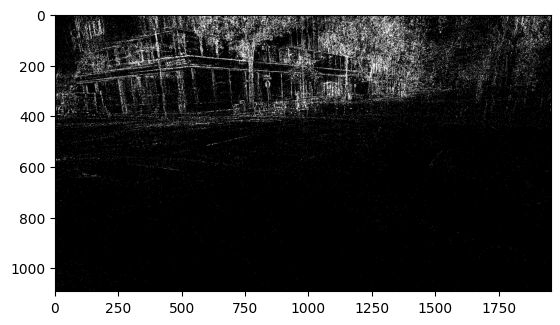

In [13]:
# Visualize grayscale projected view 

import matplotlib.pyplot as plt 

# We get inverted projection, so I will rotate 

# img = np.rot90(img.numpy(), 2) 
# img = torch.fliplr(img) 

plt.imshow(img, cmap='gray') 
plt.show()